In [ ]:
from google.colab import drive
drive.mount('...')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_parquet('/All_Sparcs_Dataset/sparcs_all_years_3.parquet')

Doing all the steps before modelling

In [ ]:
#cols to one-hot encode
categorical_cols = ['Gender','Race','Ethnicity','Payment Typology 1','Emergency Department Indicator','APR Medical Surgical Description','CCSR Diagnosis Code','CCSR Procedure Code','APR DRG Code']

print("Encoding the data, this will add may new columns")
df = pd.get_dummies(df, columns = categorical_cols, drop_first=True)

Encoding the data, this will add may new columns


In [ ]:
df.shape

(1217008, 441)

In [ ]:
#converting the risk of mortality col to int64
mapping_dict = {
    'Minor': 1,
    'Moderate': 2,
    'Major': 3,
    'Extreme': 4
}
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace(mapping_dict)

In [ ]:
print(df.dtypes)

Length of Stay                  int64
APR Severity of Illness Code    int64
APR Risk of Mortality           int64
Birth Weight                    int64
Gender_M                         bool
                                ...  
APR DRG Code_633                 bool
APR DRG Code_634                 bool
APR DRG Code_636                 bool
APR DRG Code_639                 bool
APR DRG Code_640                 bool
Length: 441, dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# we have to scale the birthweight of the train set and test set seperately,
#if the whole dataset is scaled at once the train set will peep into the test set(data leakage)
target = 'Length of Stay'
col_to_scale = ['Birth Weight']
#col_to_scale = ['Birth Weight','APR Severity of Illness Code','APR Risk of Mortality']

In [ ]:
#train-test split
X = df.drop(columns=[target])
y = df[target]
# splitting data int train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#scaling
scaler = StandardScaler()
# Use .loc to avoid SettingWithCopy warnings
X_train.loc[:, col_to_scale] = scaler.fit_transform(X_train[col_to_scale])
X_test.loc[:, col_to_scale] = scaler.transform(X_test[col_to_scale])

In [ ]:
print(" DATA READY!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print("-" * 30)

# **EXP - 3**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f" GPU DETECTED: {gpus[0].name}")

else:
    print(" NO GPU DETECTED")

 GPU DETECTED: /physical_device:GPU:0


In [ ]:

np.random.seed(42)
tf.random.set_seed(42) # this is done to make things reproducible

# -----------------------
# 1. Log-transform target
# -----------------------
print("Applying Log-Transformation to Target...")
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)


Applying Log-Transformation to Target...


In [ ]:
# 3. Model architecture
# -----------------------
print("Building Neural Network...")

model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(256, activation='relu'),
    BatchNormalization(), # Helps the model learn faster and more stably
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='linear')
])

Building Neural Network...


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)# adam optimizer used

# Huber is more robust to outliers than pure MSE on log scale
model.compile(optimizer=opt, loss=Huber(delta=1.0), metrics=['mae'])

In [ ]:
# 4. Callbacks
# -----------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# -----------------------

In [ ]:
# 5. Training
# -----------------------
print("Training...")
history = model.fit(
    X_train, y_train_log,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# -----------------------

Training...
Epoch 1/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 0.0791 - mae: 0.2693 - val_loss: 0.0401 - val_mae: 0.1958 - learning_rate: 0.0010
Epoch 2/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0420 - mae: 0.2068 - val_loss: 0.0392 - val_mae: 0.1974 - learning_rate: 0.0010
Epoch 3/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0412 - mae: 0.2052 - val_loss: 0.0389 - val_mae: 0.1979 - learning_rate: 0.0010
Epoch 4/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.0407 - mae: 0.2043 - val_loss: 0.0387 - val_mae: 0.1981 - learning_rate: 0.0010
Epoch 5/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0405 - mae: 0.2037 - val_loss: 0.0386 - val_mae: 0.1977 - learning_rate: 0.0010
Epoch 6/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0402 - mae: 0.2030 - val_loss: 0.0385 - val_mae: 0.1964 - learning_rate: 0.0010
Epoch 7/200
12171/12171 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0400 - mae: 0.2028 - val_loss: 0

In [ ]:
# 6. Evaluation
# -----------------------
print("\nPredicting...")
dl_pred_log = model.predict(X_test, batch_size=128)

# Back to LOS in days
dl_pred_days = np.expm1(dl_pred_log).ravel()  # ravel to 1D

dl_rmse = root_mean_squared_error(y_test, dl_pred_days)

print("-" * 30)
print("Deep Learning Results")
print(f"RMSE: {dl_rmse:.4f}")
print("-" * 30)



Predicting...
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
------------------------------
Deep Learning Results
RMSE: 2.1169
------------------------------


In [ ]:
baseline_rmse = 2.1787
if dl_rmse < baseline_rmse:
    print(f"SUCCESS! New RMSE {dl_rmse:.4f} beats Baseline {baseline_rmse}!")
else:
    print(f"Still trying... Gap is {dl_rmse - baseline_rmse:.4f}")

SUCCESS! New RMSE 2.1169 beats Baseline 2.1787!


Hence a lower rmse than the baseline rmse of the random forest regressor is achieved

Plots for our result

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a DataFrame for plotting
results_df = pd.DataFrame({
    'Actual LOS': y_test,
    'Predicted LOS': dl_pred_days
})

# Calculate residuals (errors)
results_df['Error'] = results_df['Actual LOS'] - results_df['Predicted LOS']


In [ ]:
results_df.head()

,Actual LOS,Predicted LOS,Error
431903,2,1.976127,0.023873
288077,2,2.385186,-0.385186
476119,2,2.384830,-0.384830
423563,3,2.297368,0.702632
736869,2,1.701568,0.298432


In [ ]:
results_df['Actual LOS'].value_counts()

,count
Actual LOS,
2,129037
3,51476
1,31927
4,12362
5,3808
6,2222
7,1988
8,1226
9,1007


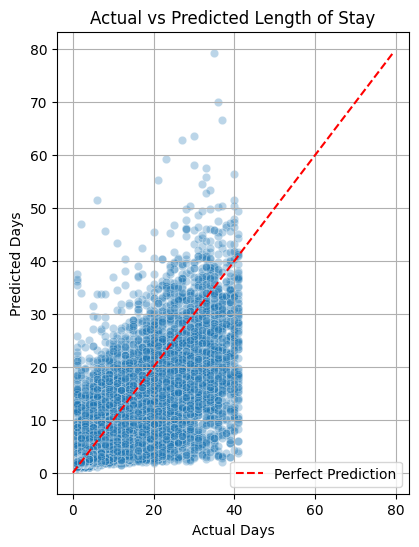

In [ ]:
# --- PLOT 1: Actual vs Predicted ---
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Actual LOS', y='Predicted LOS', data=results_df, alpha=0.3)
# Draw the perfect prediction line
max_val = max(results_df['Actual LOS'].max(), results_df['Predicted LOS'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Length of Stay')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.legend()
plt.grid(True)

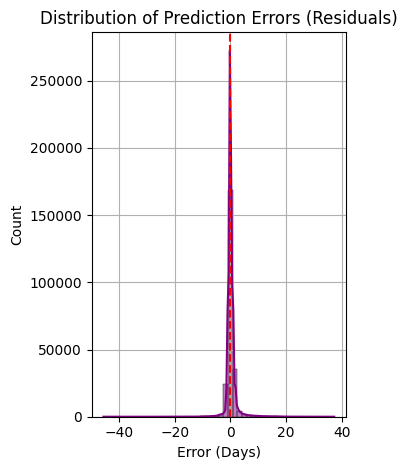

In [ ]:
# --- PLOT 2: Error Distribution ---
plt.subplot(1, 2, 2)
sns.histplot(results_df['Error'], bins=50, kde=True, color='purple')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Days)')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#saving the model for further use
model.save("Final_DL_model_LOS.keras")

# **SHAP integration**

In [ ]:
!pip install shap

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
shap.initjs() #initialized JavaScipt for plots

Preparation of background data.

In [ ]:
#Shap needs a random subset of training data for understanding baselines
background_data = X_train.sample(200, random_state=42).astype('float32').values

Creating the explainer and linked the model

In [ ]:
explainer = shap.DeepExplainer(model, background_data) # here the background data is used to calculate the baseline

The explainer is given the model and a small portion of the training set(X_train)

Calculating shap values

We will test the explainer in a small portion of test subset(X_test) . Both the training and testing data is converted to numpy arrays of float32 type since it's a requirement of shap here(to get continuous float vals)

In [ ]:
test_subset = X_test.iloc[:200].astype('float32').values
shap_values = explainer.shap_values(test_subset)
#For regression:shap_values → shape (n_samples, n_features)

In [ ]:
# shap_values might return a list for some TF models.
# If len(shap_values) == 1, we just take the first element.
if isinstance(shap_values, list):
    shap_values = shap_values[0]

In [ ]:
print(f"SHAP Values Shape: {shap_values.shape}")
print(f"Features Shape:    {test_subset.shape}")

SHAP Values Shape: (200, 440, 1)
Features Shape:    (200, 440)


so there is a shape issue, We  need to flatten that last dimension to turn (200, 440, 1) into (200, 440) i.e. n_samples, n_features

In [ ]:
# Preparing Features (Kept as DataFrame for column names)
# Ensured it is float32 to match the SHAP calculation
X_test_subset_df = X_test.iloc[:200].astype('float32')#this is for plotting purpose only, not converted to numpy array

# We take the current 3D array (200, 440, 1) and keep only the first 2 dimensions
# This converts it to (200, 440)
shap_values_2d = shap_values[:, :, 0]

print(f"Old Shape: {shap_values.shape}")     # (200, 440, 1)
print(f"New Shape: {shap_values_2d.shape}")  # (200, 440) <-- Matches Features!



Old Shape: (200, 440, 1)
New Shape: (200, 440)


Generating the plots

The Global Feature Importance Plot:

<Figure size 640x480 with 0 Axes>

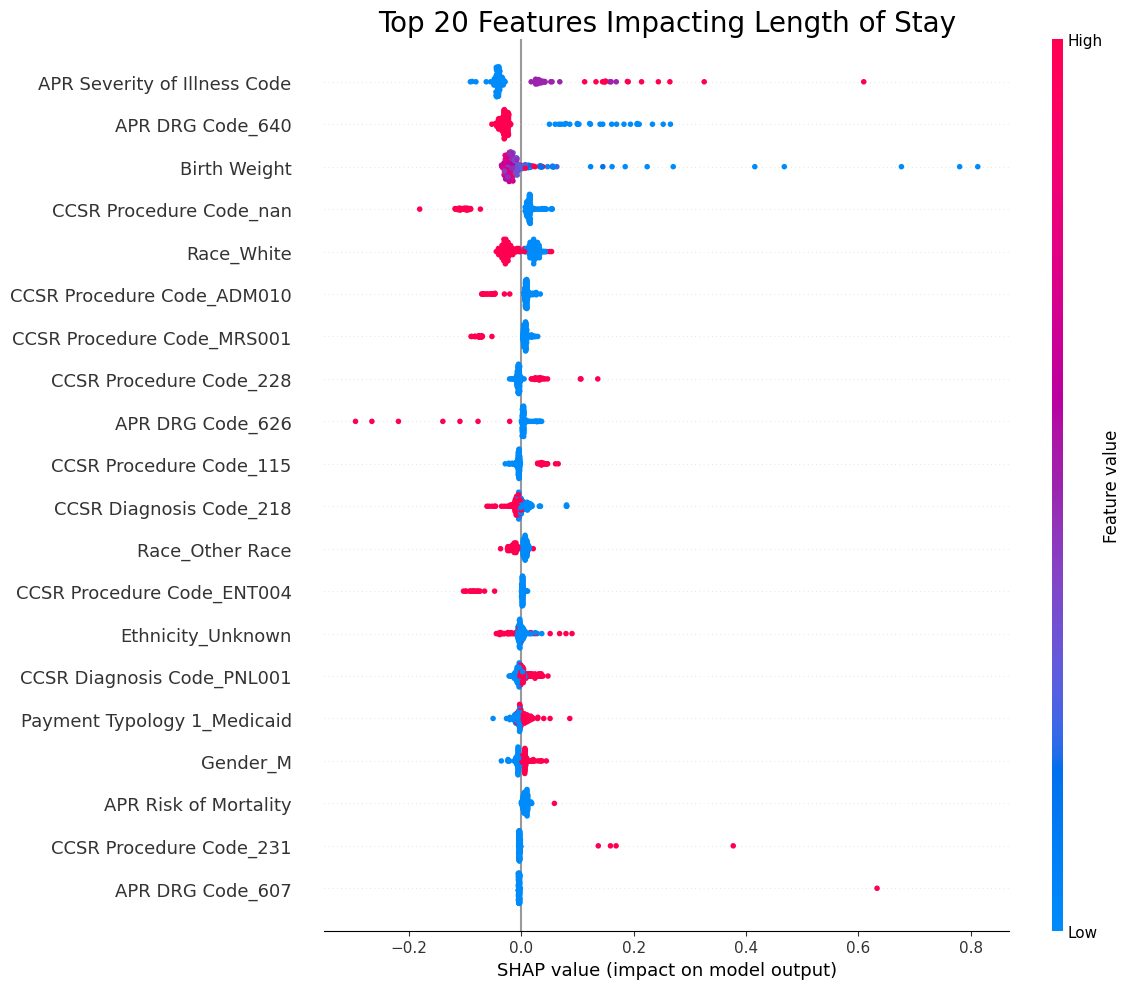

In [ ]:
# 3. Generate the Summary Plot
plt.clf() # Clear any old broken plots
f = plt.figure(figsize=(12, 10))

shap.summary_plot(
    shap_values_2d,      # Use the fixed 2D array
    X_test_subset_df,    # Use the DataFrame for names
    max_display=20,      # Show top 20 features
    show=False,          # Don't show immediately
    plot_size=None       # Use our figure size
)

plt.title("Top 20 Features Impacting Length of Stay", fontsize=20)
plt.tight_layout()
plt.show()



1.   Y-Axis (Feature Rank): Variables are listed in descending order of importance. The feature at the very top (APR Severity of Illness Code) is the #1 most influential predictor in the entire model.
2.   X-Axis (SHAP Value): This measures the impact on the model's output (Log-Length of Stay). Right Side ($>0$): Increases the predicted Length of Stay.Left Side ($<0$): Decreases the predicted Length of Stay.


1.   Colors (Feature Value):

<font color="red">Red Dots</font>: High feature values (e.g., High Severity, or "True" for a diagnosis).

<font color="blue">Blue Dots</font>: Low feature values (e.g., Low Severity, or "False").






Understanding our findings:


---


1.   Severity is the Primary Driver (APR Severity of Illness Code)   
Observation: The <font color="red">Red dots</font> (High Severity) are pushed far to the right (positive SHAP). The <font color="blue">Blue dots</font> (Low Severity) are on the left.  
Interpretation: "As the severity of illness increases, the predicted Length of Stay significantly increases. This confirms the model has correctly learned that sicker patients require more time."
2.   Birth Weight is Protective (Birth Weight)   
Observation: The <font color="red">Red dots</font> (High Birth Weight) are clustered on the left (negative SHAP). The <font color="blue">Blue dots</font> (Low Birth Weight) spread to the right.  
Interpretation: "Higher birth weight (healthier babies) is associated with a reduction in Length of Stay. Conversely, low birth weight is a risk factor that extends the hospital stay."




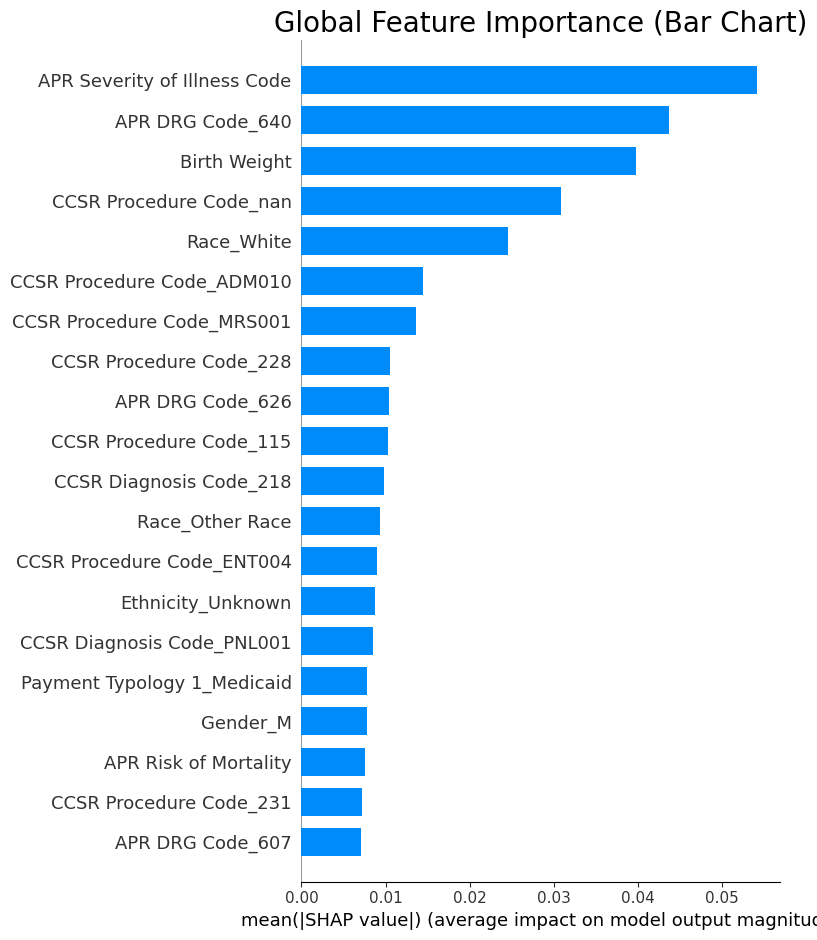

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("Global Feature Importance (Bar Chart)", fontsize=20)

shap.summary_plot(
    shap_values_2d,
    X_test_subset_df,
    plot_type="bar",  # <--- Change to Bar chart
    max_display=20,
    show=True
)

**Picking a specific baby and explaining model prediction**

In [ ]:
# Pick a specific patient
patient_index = 0
# getting that patient's shap value
single_patient_shap = shap_values_2d[patient_index]

print(single_patient_shap.shape)

(440,)


In [ ]:
# Extracting base val (The average log-prediction)
# DeepExplainer usually returns a list/array. We need the float number.
base_value = explainer.expected_value

Checking Does base_value have a .numpy() method Because in TensorFlow:
TensorFlow tensors → have .numpy()
but
NumPy floats/arrays → do NOT

In [ ]:
hasattr(base_value, 'numpy')

True

In [ ]:
#hence we need to convert the tensor to numpy
if hasattr(base_value, 'numpy'):
    base_value = base_value.numpy()

In [ ]:
#if base_value is a list, will take the 1st item only
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0]

In [ ]:
base_value = float(base_value)

print(f"Base Value: {base_value}")

Base Value: 1.2284594774246216


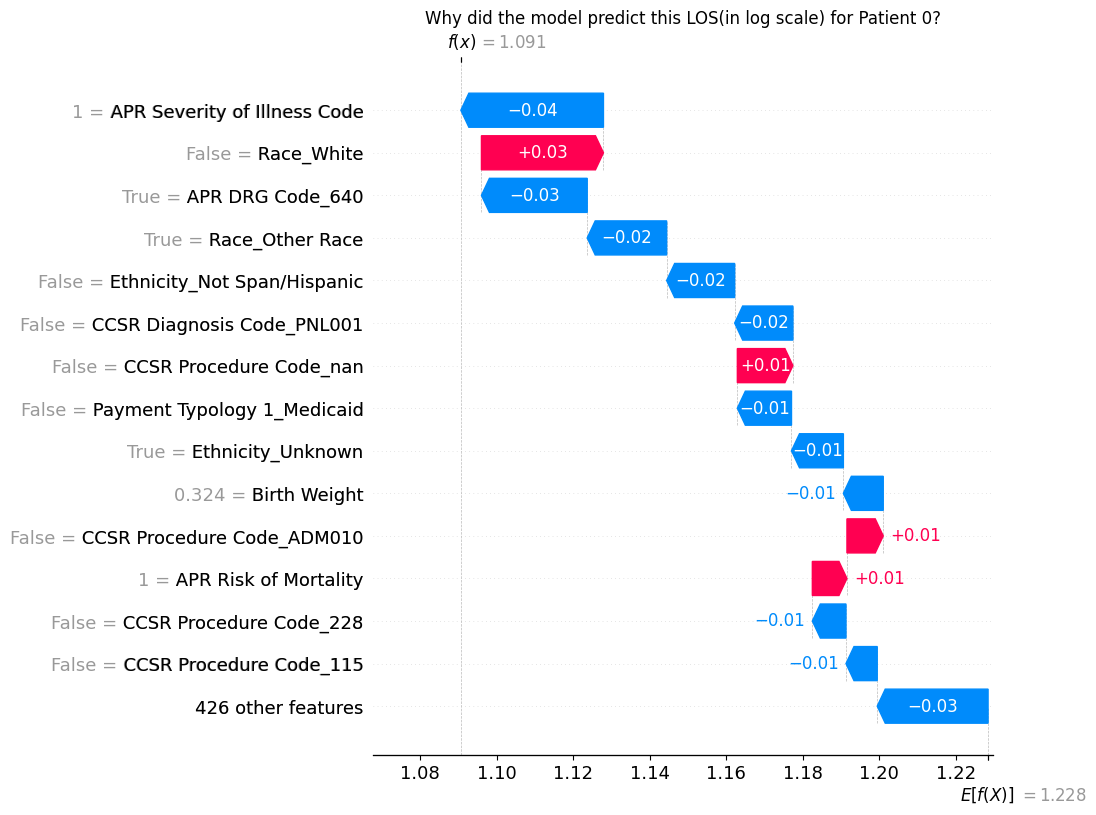

In [ ]:
# Create a Waterfall plot for this patient
# We use shap.Explanation obj to format the data correctly for the new plotting API
explanation = shap.Explanation(
    values= single_patient_shap,
    base_values=base_value,
    data=X_test.iloc[patient_index],
    feature_names=X_test.columns
)

plt.figure(figsize=(10, 6))
plt.title(f"Why did the model predict this LOS(in log scale) for Patient {patient_index}?")
shap.plots.waterfall(explanation, show=True,max_display=15)

The Interpretation of this waterfall plot:


1.   The Starting Point: The Base Value (E[f(X)]). This is the average expected Length of Stay (in log-scale) for the entire dataset. Without knowing anything about a specific patient, the model would guess this baseline value.(but the basevalue is created from the background data)
2.   The Journey: Feature Contributions (The Arrows)
Each horizontal bar represents a specific feature pushing the prediction away from the average. Blue Bars ($\leftarrow$ Negative Impact): These features reduced the predicted Length of Stay. Red Bars ($\rightarrow$ Positive Impact): These features increased the predicted Length of Stay.


1. The Destination: The Final Prediction ($f(x)$)This is the final Log-Length of Stay predicted for this specific baby after summing up all the red (+) and blue (-) contributions.


In [ ]:
import math
num_on_plot=1.091 # the final no. at the end of waterfall
print(f"Predicted Days: {math.exp(num_on_plot) - 1}")

Predicted Days: 1.977249834268501


In [ ]:
print(f"Actual Days: {y_test.iloc[patient_index]}")

Actual Days: 2


Hence they are almost same, as the predicted LOS from the original test set, is same as the actual LOS from the test set. Hence it's a success.